This is code from the blog post at [machine learning mastery](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

/tmp/ipykernel_5485/814560963.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


/tmp/ipykernel_5485/814560963.py:8: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)


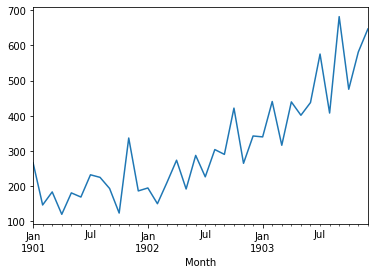

In [1]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
 
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
series = read_csv('data/shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
pyplot.show()

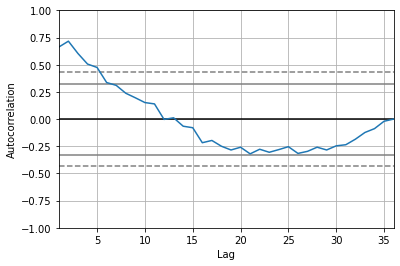

In [2]:
from pandas.plotting import autocorrelation_plot
 
autocorrelation_plot(series)
pyplot.show()

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(4, 2, 4)   Log Likelihood                -190.133
Date:                Mon, 30 May 2022   AIC                            398.266
Time:                        10:27:58   BIC                            412.003
Sample:                    01-01-1901   HQIC                           402.951
                         - 12-01-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2054      0.404     -2.987      0.003      -1.996      -0.414
ar.L2         -0.9939      0.584     -1.703      0.089      -2.138       0.150
ar.L3         -0.2730      0.485     -0.563      0.5

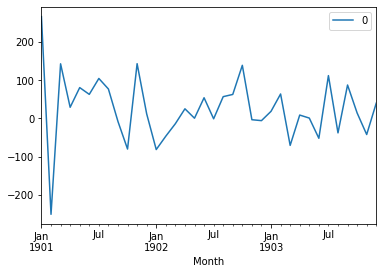

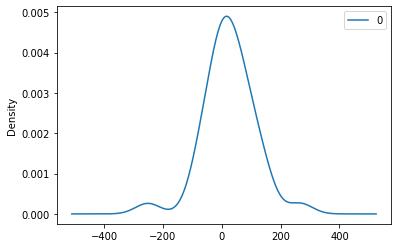

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame

# fit model
model = ARIMA(series, order=(4,2,4))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
print(type(model_fit.resid))
residuals = DataFrame(model_fit.resid)
print(residuals.mean())
# summary stats of residuals
print(residuals.describe())
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
_ = pyplot.show()


predicted=362.963133, expected=342.300000
predicted=324.922062, expected=339.700000
predicted=409.462921, expected=440.400000
predicted=362.587141, expected=315.900000
predicted=380.809167, expected=439.300000
predicted=327.137344, expected=401.300000
predicted=456.764303, expected=437.400000
predicted=452.811955, expected=575.500000
predicted=466.968800, expected=407.600000
predicted=560.786164, expected=682.000000
predicted=459.686967, expected=475.300000
predicted=688.562730, expected=581.300000
predicted=575.919215, expected=646.900000
Test RMSE: 69.689


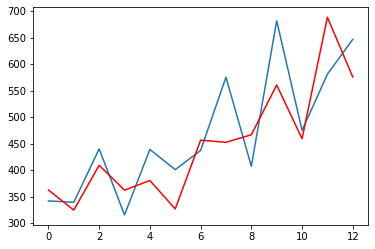

In [14]:
# evaluate an ARIMA model using a walk-forward validation
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(4,2,4))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [24]:
# lets get the best result we can with a grid search of p, d, and q
# see the site here: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

import warnings
warnings.filterwarnings("ignore")

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    mean = model_fit.resid.mean()
    return error, mean

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse, mean = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f, mean=%.3f' % (order,mse,mean))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [27]:
# evaluate parameters
p_values = range(4,13)
d_values = range(3,10)
q_values = range(3,10)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(4, 3, 3) MSE=4609.668, mean=-14.908
ARIMA(4, 3, 4) MSE=105077702.484, mean=-17.905
ARIMA(4, 4, 3) MSE=9470.045, mean=9.286
ARIMA(4, 4, 4) MSE=7230.415, mean=12.172
ARIMA(4, 5, 3) MSE=14268.700, mean=-19.947
ARIMA(4, 5, 4) MSE=2821471244678.974, mean=-24.530
ARIMA(4, 6, 3) MSE=1474073586622715648.000, mean=743103309.384
ARIMA(4, 6, 4) MSE=499785846266377.312, mean=1.435
ARIMA(4, 7, 3) MSE=1563275838369234.750, mean=1.007
ARIMA(4, 7, 9) MSE=337069.892, mean=0.024
ARIMA(4, 8, 3) MSE=1834685104967457701888.000, mean=-7.810
ARIMA(4, 8, 9) MSE=529809.102, mean=-0.163
ARIMA(4, 9, 3) MSE=2974639354498834432.000, mean=37.128
ARIMA(4, 9, 9) MSE=1029087.539, mean=-0.740
ARIMA(5, 3, 3) MSE=3860.388, mean=-15.847
ARIMA(5, 3, 4) MSE=231004260.392, mean=-16.849
ARIMA(5, 4, 3) MSE=8147.884, mean=7.378
ARIMA(5, 4, 4) MSE=6611.548, mean=12.002
ARIMA(5, 5, 3) MSE=18557.030, mean=-18.373
ARIMA(5, 5, 4) MSE=6186130781457.059, mean=-26.108
ARIMA(5, 6, 3) MSE=91436012922673.719, mean=-13.610
ARIMA(5, 7